In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [21]:
df_1 = pd.read_csv("bengaluru_house_prices.csv")
df_1.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00


In [22]:
df_1.shape

(13320, 9)

In [23]:
df_1 = df_1.drop(['area_type','society','balcony','availability'],axis=1)
df_1.shape

(13320, 5)

In [24]:
df_1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [25]:
df_1 = df_1.dropna()
df_1.shape

(13246, 5)

## Feature Engineering

In [26]:
df_1['bhk'] = df_1['size'].apply(lambda row: int(row.split(" ")[0]))
df_1.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [27]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [28]:
df_1[~df_1['total_sqft'].apply(is_float)].head(10)
df_1.shape

(13246, 6)

In [29]:
def convert_sqft_to_num(num):
    x = num.split('-')
    if len(x) == 2:
        return (float(x[0])+float(x[1]))/2
    try:
        return float(num)
    except:
        return None   

In [30]:
# converting values
df_1.total_sqft = df_1.total_sqft.apply(convert_sqft_to_num)
df_1 = df_1[df_1.total_sqft.notnull()]
df_1.shape

(13200, 6)

In [31]:
# calculating price_per_sqft
df_1['price_per_sqft'] = df_1['price']*1_00_000 / df_1['total_sqft']
df_1.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [32]:
df_1.location = df_1.location.apply(lambda row: row.strip())
location_ = df_1['location'].value_counts(ascending=False)
location_ # series

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [33]:
len(location_[location_>10])

240

In [34]:
len(location_[location_<=10])

1047

In [35]:
location_less_than_10 = location_[location_<=10]
location_less_than_10.head(3)
location_less_than_10.shape

(1047,)

In [36]:
# assign other to location rows <= 10
df_1.location = df_1.location.apply(lambda row: 'other' if row in location_less_than_10 else row)
df_1.shape

(13200, 7)

## Outlier Removing

In [37]:
# business logic : 1 bhk can not less than 300 sqft
df_1 = df_1[~(df_1.total_sqft/df_1.bhk < 300)]
df_1.shape

(12456, 7)

In [38]:
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df_2 = remove_outliers(df_1)
df_2.size

71694

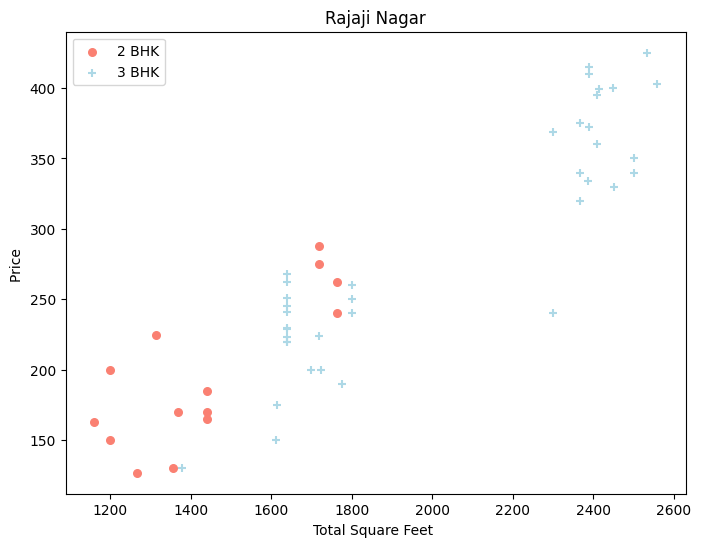

In [39]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.rcParams['figure.figsize'] = (8,6)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='salmon',label='2 BHK', s=30)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='lightblue',label='3 BHK', s=30)
    plt.xlabel("Total Square Feet ")
    plt.ylabel("Price ")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df_2,"Rajaji Nagar")

In [40]:
df_2[df_2.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [41]:
# It is unusual to have 2 more bathrooms than number of bedrooms in a home**
df_2 = df_2[df_2.bath < df_2.bhk+2]
df_2.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [42]:
# removing columns
df_2 = df_2.drop(['size','price_per_sqft'],axis=1)
df_2.head(2)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3


## One Hot Encoding For Location

In [43]:
location_dummies = pd.get_dummies(df_2.location)
location_dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
df_2 = pd.concat([df_2,location_dummies.drop('other',axis='columns')],axis='columns')
df_2.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
df_2 = df_2.drop('location',axis='columns')
df_2.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Model

In [46]:
# splitting data feature and target
X = df_2.drop(['price'],axis='columns')
Y = df_2["price"]


In [47]:
# splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

In [48]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=10)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7783231781110657

In [49]:
# cross validation 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
np.random.seed(42)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, Y, cv=cv)


array([0.81567128, 0.87002069, 0.80226713, 0.82194915, 0.7501478 ])

In [50]:
#  Find best model using GridSearchCV

from sklearn.model_selection import GridSearchCV
np.random.seed(10)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


gs_model = GridSearchCV(LinearRegression(), {
    'n_jobs': np.arange(1, 100, 10)
},
    cv=cv, return_train_score=False)
gs_model.fit(X, Y)

print(gs_model.best_params_)
print(gs_model.best_score_)

# final model
gs_model

{'n_jobs': 1}
0.8120112079272609


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=LinearRegression(),
             param_grid={'n_jobs': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])})

In [51]:
# export model
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(gs_model,f)

## Test model


In [52]:
X.head(1)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
def predict_(location : str, sqft : int, bath : int, bhk : int):
    loc_index = np.where(X.columns == location)[0][0]
    
    # print((np.where(X.columns == location))[0][0])
    
    x = np.zeros(len(X.columns))
    x[0], x[1], x[2] = sqft, bath, bhk

    if loc_index >= 0:
        x[loc_index] = 1
    # print(x)

    return gs_model.predict([x])[0]

# alter values for prediction
predict_('1st Phase JP Nagar', 1500, 2, 3)

/Users/ankitgupta/MyStuff/python-ds-ml/code_env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


116.94496817186489